In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import plotly.express as px
from scipy.stats import ttest_ind
import scipy
import warnings
import os
from datetime import datetime as dt
warnings.filterwarnings("ignore")
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

os.chdir('/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/')

Mounted at /content/drive


In [3]:
## Opening data from cleaned data
file=open('Data/Cleaned/jurisdiction_temporal.csv')

#Creating main data frame: correcting for date format and making sure NA values are removed
df=pd.read_csv(file)
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.reset_index()
df=df.drop('Unnamed: 0',axis=1)
df.dropna(subset=['Mono.Initiated.Coverage'], inplace=True)
states=df['State'].unique()
print(len(df.loc[df['Mono.Initiated.Coverage'].isna()]))

0


In [4]:
# Get non-incarcerated vacc data
df_noninc=pd.read_csv("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv")
df_noninc.Location.unique()
df_noninc = df_noninc[df_noninc.Location == 'US']
df_noninc['Date']=pd.to_datetime(df_noninc['Date'], format="%m/%d/%Y")
df_noninc = df_noninc[(df_noninc.Date > '2/14/2021') & (df_noninc.Date < '04/01/2022')]
df_noninc['Administered_Dose1_Pop_Pct'] = df_noninc['Administered_Dose1_Pop_Pct']/100 # convert to proportion


In [5]:

##COMBINING NON-INCARCERATED AND INCARCERATED VACCINATION DATA
from datetime import timedelta

## loop adds data to match the information from the week before.
for date in df_noninc['Date'].unique():
  national=df_noninc[df_noninc['Date']==date].reset_index()['Administered_Dose1_Pop_Pct'].iloc[0]

  week_before=[]
  for i in range (1,8):
    week_entry=date - timedelta(i)
    week_before.append(week_entry)
  df_date=df.loc[df['Date'].isin(week_before)]
  df_date.sort_values('Date')
  number_above=0

  for state in df_date['State'].unique():
    coverage=df_date.loc[df_date['State']==state].reset_index()['Mono.Initiated.Coverage'].iloc[0]
    if coverage>national:
      number_above=number_above+1

# Calculating the vaccination rate for all states
We need all states because we also will use the vaccinaiton rate to determine days to saturation

In [6]:
## Calculate the vaccination rate of change
df["Rate.Change"] = " "
df['Differences']=np.nan
df_concat=pd.DataFrame()


for state in states:
    df_state=df.loc[df['State']==state]
    df_state['Rate.Change'][0]=np.nan
    df_state['Rate.Change'][1]=np.nan
    ##Calculations for rate of change
    df_state['Differences']=((np.log(df_state['Mono.Initiated.Coverage']))-(np.log(df_state['Mono.Initiated.Coverage'].shift(1))))
    df_state['Days_since_last']=df_state['Days_since_last'].astype(float, errors = 'raise')
    df_state['Rate.Change']=df_state['Differences']/(df_state['Days_since_last']/7)
    df_concat= pd.concat([df_state,df_concat])
df=df_concat ##renaming the new dataframe with all the stored rates as df




Takeawy: Calculating days to Saturation needs to be (0--> 0.005) and initial rate should be 30 days

## Function to match states to their abbreviations

In [7]:
##Creating a fucntion to add in state name abbreviations
states_abbrevs = {'AK':'Alaska','AL':'Alabama','AR':'Arkansas','AZ':'Arizona', 'CA':'California','CO':'Colorado',
    'CT':'Connecticut','DC':'District of Columbia','DE':'Delaware','FL':'Florida','GA':'Georgia',
    'HI':'Hawaii','IA':'Iowa','ID':'Idaho','IL':'Illinois','IN':'Indiana','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'MA':'Massachusetts','MD':'Maryland','ME':'Maine','MI':'Michigan','MN':'Minnesota','MO':'Missouri','MS':'Mississippi',
    'MT':'Montana','NC':'North Carolina','ND':'North Dakota','NE':'Nebraska','NH':'New Hampshire','NJ':'New Jersey',
    'NM':'New Mexico','NV':'Nevada','NY':'New York','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah',
    'VA':'Virginia','VT':'Vermont','WA':'Washington','WI':'Wisconsin','WV':'West Virginia','WY':'Wyoming'}


def best_match(x):
    if len(x) == 2: # Try another way for 2-letter codes
        for a,n in states_abbrevs.items():
            if len(n.split()) == 2:
                if "".join([c[0] for c in n.split()]).lower() == x.lower():
                    return a.lower()
    new_rx = re.compile(r"\w*".join([ch for ch in x]), re.I)
    for a,n in states_abbrevs.items():
        if new_rx.match(n):
            return a.upper()

## Calculating Initial Vaccination Rate

In [8]:
bad_rate_states=[] ##Creating a list to store states have a rate greater than 50% in a given week
for state in states:  ##Checking each state
    df_state=df.loc[df['State']==state]
    df_state.sort_values(by='Date',ascending=True)
    xs=df_state.index.to_list()
    first=xs[0] ##fiest calue in th index
    start_rate=df_state['Mono.Initiated.Coverage'][first] ##pulling the first value from every state

    if start_rate>0.5:
        bad_rate_states.append(state)

states=list(states)
states_for_rates=[i for i in states if i not in bad_rate_states] #list of states that are good to use for Calculating rate
## Creating a list of states without the federal prison designation
statesonly=states
try:
  statesonly.remove('Federal')
except:
  x=1

In [9]:
## Creating a dataset to store covariates for analysis starting with mean initial rate
values=[] ##empty list to store tuples for the mean and std for rate of change
for state in states_for_rates:
    df_state=df.loc[df['State']==state]
    df_state=df_state.loc[df_state['Days']<30] ## Initial rate for the first 30 days of the vaccination campaign
    df_state.dropna(subset=['Rate.Change'],inplace=True)
    mean=df_state['Rate.Change'].mean()
    values.append((state,mean))
df_means = pd.DataFrame(values, columns=['State','Rate_change_mean_perday'])
df_means['Rate_change_mean_perweek']=df_means['Rate_change_mean_perday']*7



df_means=df_means.loc[df_means['State'].isin(statesonly)]
df_means['state_code'] = df_means['State'].apply(lambda x: best_match(x))

## Calculating vaccination saturation

In [10]:
def all_5_list_values(list1,thresh):
    return all(x < thresh for x in list1)

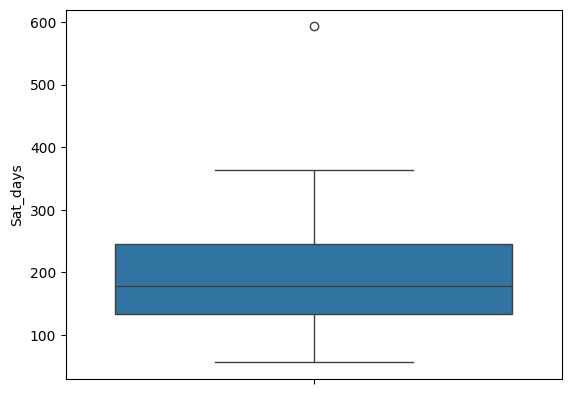

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def saturation_sensistivity(thresh):
  ##Creating a dataset to keep track of the states days to saturation (known as slow date in this code)
  state_stop=[]
  for state in states:## for every state in the data set
      df_state=df.loc[df['State']==state] ##Create data for just that state

      df_state=df_state.sort_values(by='Date',ascending=True)
      days_saturated=[]
      for date in df_state['Date'].unique():
        start_date = date
        end_date = date + timedelta(weeks=5)
        # Subset the dataframe for the 5-week window
        df_subset = df_state[(df_state['Date'] >= start_date) & (df_state['Date'] < end_date)]
        rate_changes=df_subset['Rate.Change'].tolist()
        if all_5_list_values(rate_changes,thresh)==True:
          date=max(df_subset['Date'])
          days_saturated.append(date)
      if len(days_saturated)>0:
        first_sat=min(days_saturated)
        days=df_state['Days'][df_state['Date']==first_sat].iloc[0]
        state_stop=state_stop+[[state,first_sat,days]]
  df_slow=pd.DataFrame(state_stop,columns=['State','Sat_date','Sat_days'])
  sns.boxplot(y='Sat_days', data=df_slow)
  plt.show()
  return df_slow

df_slow=saturation_sensistivity(0.005)


In [12]:
df

,index,Date,State,Residents.Initiated,Month,Year,Population_Dec2021,Residents.Initiated.Rate,Prioritization?,Date_prioritized,Phase_state,Mono.Initiated.Coverage,Days,Days_since_last,Rate.Change,Differences
1926,54,2021-04-04,Alabama,871.0,4,2021,18279.0,0.047650,yes,2021-04-01,1B,0.047650,0,NaN,NaN,NaN
1927,55,2021-04-11,Alabama,1184.0,4,2021,18279.0,0.064774,yes,2021-04-01,1B,0.064774,7,7.0,0.307012,0.307012
1928,56,2021-04-18,Alabama,1740.0,4,2021,18279.0,0.095191,yes,2021-04-01,1B,0.095191,14,7.0,0.384987,0.384987
1929,57,2021-04-25,Alabama,1972.0,4,2021,18279.0,0.107883,yes,2021-04-01,1B,0.107883,21,7.0,0.125163,0.125163
1930,58,2021-05-02,Alabama,2798.0,5,2021,18279.0,0.153072,yes,2021-04-01,1B,0.153072,28,7.0,0.349857,0.349857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,7277,2021-09-19,Wisconsin,16588.0,9,2021,20088.0,0.825767,yes,2021-03-01,1C,0.825767,175,7.0,0.016901,0.016901
2045,7278,2021-09-26,Wisconsin,16606.0,9,2021,20088.0,0.826663,yes,2021-03-01,1C,0.826663,182,7.0,0.001085,0.001085
2046,7279,2021-10-03,Wisconsin,16659.0,10,2021,20088.0,0.829301,yes,2021-03-01,1C,0.829301,189,7.0,0.003187,0.003187
2047,7280,2021-10-10,Wisconsin,16675.0,10,2021,20088.0,0.830098,yes,2021-03-01,1C,0.830098,196,7.0,0.000960,0.000960


In [13]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
results=[]
states=list(states)
states.remove('Federal')
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # 5x5 grid
axes = axes.flatten()

for i, state in enumerate(states[:25]):  # only first 25 states
    ax = axes[i]
    df_state = df.loc[df['State'] == state]
    x = df_state['Days'].values
    y = df_state['Mono.Initiated.Coverage'].values

    # Updated logistic with shift
    def logistic(x, S, r, x0):
        return S / (1 + np.exp(-r * (x - x0)))

    p0 = [min(1, max(y)), 1, np.median(x)]  # Initial guesses
    bounds = ([0, -np.inf, -np.inf], [1, np.inf, np.inf])
    params, _ = curve_fit(logistic, x, y, p0=p0, bounds=bounds)
    S, r, x0 = params

    x_fit = np.linspace(min(x), max(x), 500)  # Start fit where data starts
    y_fit = logistic(x_fit, S, r, x0)


    ax.plot(x_fit, y_fit, color='pink', label='Fit')
    ax.scatter(x, y, color='purple', s=10, label='Data')
    ax.set_title(state)
    ax.set_xlabel('Days')
    ax.set_ylabel('Coverage')
    ax.grid(True)

    results.append({'State': state, 'S': round(S, 3), 'r': round(r, 3), 'x0': round(x0, 1)})


# Remove any unused subplots
for j in range(i + 1, 25):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('Graphs/logistic_fits.jpg')
plt.show()
fit_results_df = pd.DataFrame(results)
fit_results_df.to_csv('Data/Cleaned/fit_results.csv', index=False)
fit_results_df

ValueError: list.remove(x): x not in list

In [14]:
state_stop=[]
for state in states:
  fit_results_df.loc[fit_results_df['State']==state]
  saturation=fit_results_df.loc[fit_results_df['State']==state]['S'].iloc[0]
  df_subset=df.loc[(df['State']==state)&(df['Mono.Initiated.Coverage']>=(saturation*0.95))]
  if len(df_subset)>0:
    df_subset=df_subset.sort_values(by='Date',ascending=True)
    days=df_subset['Days'].iloc[0]
    date=df_subset['Date'].iloc[0]
    state_stop=state_stop+[[state,date,days,saturation]]
df_slow=pd.DataFrame(state_stop,columns=['State','Sat_date','Sat_days','Saturation'])

df_slow

NameError: name 'fit_results_df' is not defined

## December Coverage & Comparison to Non incarcerated

In [ ]:
##Pulling coverage for each state in the 48th week of 2021 for december non-incarcerated coverage
file_state=open('Data/Cleaned/data_county_timeseries.csv')
df_noninc=pd.read_csv(file_state)
df_noninc=df_noninc.loc[df_noninc['CASE_TYPE']=='Partial']
df_noninc=df_noninc.loc[df_noninc['WEEK']==48]
df_noninc=df_noninc.loc[df_noninc['YEAR']==2021]
df_noninc['State']=df_noninc['STATE_NAME'].replace(states_abbrevs)
df_new_december=pd.DataFrame()

In [ ]:
## Combining non incarcerated vaccination coverage with the first data entry for every state in December 2021
december=[]
df_december=pd.DataFrame()
for state in df['State'].unique():
    df_state_noninc=df_noninc.loc[df_noninc['State']==state]
    ppl_vacc=df_state_noninc['CASES'].sum()
    popn=df_state_noninc['POPN'].sum()
    state_coverage_non_inc=ppl_vacc/popn

    df_state=df.loc[df['State']==state]
    df_state_12=df_state.loc[df_state['Date'].dt.month==12]
    df_state_12=df_state_12.loc[df_state_12['Date'].dt.year==2021]
    index_list=df_state_12.index.values.tolist() ##Create a list of the indexes for the dataframe
    if len(index_list)>0:
        first=index_list[0]
        december_value=df_state_12['Mono.Initiated.Coverage'][first]
        december.append([state,december_value])
    else: december.append([state,np.nan])
    new_row=[state,december_value,state_coverage_non_inc]
    new_row=pd.DataFrame({'State':[state], 'Coverage_december':[december_value], 'non_inc_coverage':[state_coverage_non_inc]})
    df_december=pd.concat([df_december,new_row],ignore_index=True)

df_december.columns=['State', 'Coverage_december', 'non_inc_coverage']

df_december['diff_in_coverage']=df_december['Coverage_december']-df_december['non_inc_coverage']
print(df_december)

             State  Coverage_december  non_inc_coverage  diff_in_coverage
0        Wisconsin           0.625648          0.639388         -0.013740
1    West Virginia           0.625648          0.513608          0.112040
2       Washington           0.752307          0.699659          0.052648
3         Virginia           0.991188          0.655312          0.335876
4   South Carolina           0.991188          0.569763          0.421425
5     Pennsylvania           0.991188          0.771800          0.219388
6             Ohio           0.991188          0.571716          0.419471
7     North Dakota           0.991188          0.537437          0.453751
8   North Carolina           0.763953          0.692429          0.071523
9       New Jersey           0.741665          0.762555         -0.020889
10   New Hampshire           0.813614          0.845458         -0.031845
11        Missouri           0.749204          0.548351          0.200853
12        Michigan           0.697690 

## Creating dataframe with all analysis data

In [ ]:
##Combining all covariate data frames into one.
df_analysis=pd.DataFrame(df['State'].unique(),columns=['State'])
df_analysis=df_analysis.set_index('State')
df_december=df_december.set_index('State')
df_slow=df_slow.set_index('State')
df_means=df_means.set_index('State')
df_analysis=pd.concat([df_december,df_slow,df_means,df_analysis],axis=1, verify_integrity=True)
df_analysis=df_analysis.reset_index()
df_analysis['state_code'] = df_analysis['State'].apply(lambda x: best_match(x))

print(df_analysis)

             State  Coverage_december  non_inc_coverage  diff_in_coverage  \
0        Wisconsin           0.625648          0.639388         -0.013740   
1    West Virginia           0.625648          0.513608          0.112040   
2       Washington           0.752307          0.699659          0.052648   
3         Virginia           0.991188          0.655312          0.335876   
4   South Carolina           0.991188          0.569763          0.421425   
5     Pennsylvania           0.991188          0.771800          0.219388   
6             Ohio           0.991188          0.571716          0.419471   
7     North Dakota           0.991188          0.537437          0.453751   
8   North Carolina           0.763953          0.692429          0.071523   
9       New Jersey           0.741665          0.762555         -0.020889   
10   New Hampshire           0.813614          0.845458         -0.031845   
11        Missouri           0.749204          0.548351          0.200853   

In [ ]:
df_analysis.to_csv('analysis.csv')
df_analysis

,State,Coverage_december,non_inc_coverage,diff_in_coverage,Sat_date,Sat_days,Saturation,Rate_change_mean_perday,Rate_change_mean_perweek,state_code
0,Wisconsin,0.625648,0.639388,-0.013740,2021-08-22,147.0,0.738,0.561854,3.932975,WI
1,West Virginia,0.625648,0.513608,0.112040,2021-09-05,154.0,0.608,0.076864,0.538046,WV
2,Washington,0.752307,0.699659,0.052648,2021-11-21,224.0,0.776,0.138392,0.968745,WA
3,Virginia,0.991188,0.655312,0.335876,2021-11-14,294.0,1.000,0.160918,1.126429,VA
4,South Carolina,0.991188,0.569763,0.421425,2021-08-01,77.0,0.583,0.124695,0.872864,SC
5,Pennsylvania,0.991188,0.771800,0.219388,2021-08-15,132.0,0.948,NaN,NaN,PA
6,Ohio,0.991188,0.571716,0.419471,2021-05-16,91.0,0.571,0.438169,3.067183,OH
7,North Dakota,0.991188,0.537437,0.453751,2021-06-06,84.0,0.823,NaN,NaN,ND
8,North Carolina,0.763953,0.692429,0.071523,2022-05-01,455.0,1.000,0.083578,0.585048,NC
9,New Jersey,0.741665,0.762555,-0.020889,NaT,NaN,NaN,NaN,NaN,NJ


# Graphing

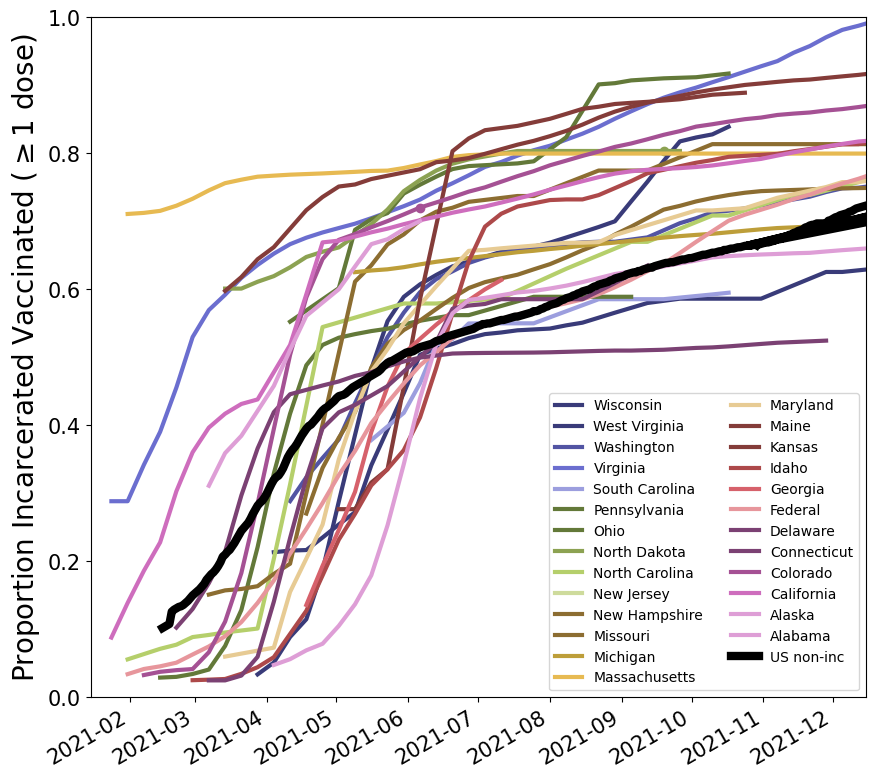

In [5]:
import geopandas as gpd

df_analysis=pd.read_csv('analysis.csv')
fig_timeseries,timeseries = plt.subplots(figsize=(10, 10))

# Get non-incarcerated vacc data
df_noninc=pd.read_csv("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv")
df_noninc.Location.unique()
df_noninc = df_noninc[df_noninc.Location == 'US']
df_noninc['Date']=pd.to_datetime(df_noninc['Date'], format="%m/%d/%Y")
df_noninc = df_noninc[(df_noninc.Date > '2/14/2021') & (df_noninc.Date < '04/01/2022')]
df_noninc['Administered_Dose1_Pop_Pct'] = df_noninc['Administered_Dose1_Pop_Pct']/100 # convert to proportion


df=pd.read_csv('Data/Cleaned/UCLA_statewide_temporal.csv')
#Creating main data frame: correcting for date format and making sure NA values are removed


df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d")
#df = df[df['Mono.Initiated.Coverage'].notna()]
df.reset_index()
df=df.drop('Unnamed: 0',axis=1)
states=df['State'].unique()

len(df['Date'].unique())
df.dropna(subset=['Mono.Initiated.Coverage'], inplace=True)
states=df['State'].unique()


colormap = plt.cm.tab20b
colors = [colormap(i) for i in np.linspace(0, 1,len(states))]
timeseries.set_prop_cycle('color', colors)

for state in states:
    df2=df.loc[df['State'] == state]
    sat_date=df_analysis.loc[df_analysis['State']==state]['Sat_date'].iloc[0]
    if pd.to_datetime(sat_date) in df2['Date'].values:
        sat_coverage=df2.loc[df2['Date']==sat_date]['Mono.Initiated.Coverage'].iloc[0]
    else:
        sat_coverage = np.nan
    for name, group in df2.groupby("State"):

        # shweta addition to smooth the time series
        group = group[['Date', 'Mono.Initiated.Coverage']]
        group = group.sort_values(by='Date')
        group = group.set_index('Date')
        group = group.rolling('28d').mean()
        group = group.reset_index()
        if pd.to_datetime(sat_date) in df2['Date'].values:
          sat_coverage=group.loc[group['Date']==sat_date]['Mono.Initiated.Coverage'].iloc[0]
        else:
          sat_coverage = np.nan

        group.plot(x='Date', y='Mono.Initiated.Coverage', ax=timeseries,label=state, linewidth=3)
        #if state in df_concat['State'].unique():
            #df3.plot('Date', 'Mono.Initiated.Coverage', ax=ax,style='--',label='_nolegend_')
        if sat_coverage != np.nan:
          timeseries.scatter(sat_date,sat_coverage)

# shweta addition: add national partial vacc time series
df_noninc.plot(x= 'Date', y= 'Administered_Dose1_Pop_Pct', color = 'black', linewidth = 6, ax=timeseries, label='US non-inc')

timeseries.set_ylim(0,1)
timeseries.legend(ncol=2, loc="best", fontsize = 10)
timeseries.set_ylabel('Proportion Incarcerated Vaccinated ($\geq 1$ dose)', fontsize=20)
timeseries.set_xlabel('')
timeseries.tick_params(axis='both', which='major', labelsize=15)
timeseries.set_xlim(['01/15/2021', '12/15/2021'])
fig_timeseries.savefig('figure1_timeseries.png',dpi=1000)
############################################################################## PLOTTING COVERAGE IN DECEMBER ###################################################################################################

df_analysis=df_analysis.rename(columns={'state_code':'STUSPS'})

fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="Coverage_december", scope="usa", color_continuous_scale='RdPu')
fig.update_layout(coloraxis_colorbar_title_text = 'December Coverage')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=20,color='black')))
fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.write_image('figure1_decembercoverage.png')
fig.show()
############################################################################## PLOTTING SATURATION ###################################################################################################
fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="Days_to_saturation", scope="usa", color_continuous_scale='RdPu')
fig.update_layout(coloraxis_colorbar_title_text = 'Days to Saturation')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=25,color='black')))

fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.write_image('figure1_saturation.png')
fig.show()
####################################################################################PLOTTING INITIAL RATE#######################################################################################
fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="intrinsic_growth", scope="usa", color_continuous_scale='RdPu')
fig.update_layout(coloraxis_colorbar_title_text = 'Initial Vaccination Rate')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=25,color='black')))

fig.write_image('figure1_initialrate.png')
fig.show()


In [2]:
pip install kaleido